In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import glob
import numpy as np
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer,SpearmanCorrelationEliminator

In [2]:
#ファイル読み込み
df = pd.DataFrame()
for i in glob.glob("train/*.csv*"):
    tmp_df=pd.read_csv(i)
    df = pd.concat([df, tmp_df],ignore_index=True)

C:\Users\osako\AppData\Local\Temp\ipykernel_4460\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_4460\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_4460\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_4460\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)


In [3]:
#欠損値確認,欠損値削除
df_rownum=df.shape[0]
df_null_column=df.columns[df.isnull().sum()==df_rownum]
df=df.drop(df_null_column,axis=1)

In [4]:
df.drop(['ID',
         '種類',
#                '地区名',
#                '最寄駅：名称',
        '市区町村コード',
#                '用途',
#                '市区町村名',
#                '間取り',
#                '建物の構造',
#                '都市計画'
              ],inplace=True,axis=1)
df["取引の事情等"].fillna(0, inplace=True)
df.loc[df["取引の事情等"] != 0, "取引の事情等"] = 1

In [5]:
#欠損値の多い列を削除
df=df.drop(['今後の利用目的'],axis=1)
#各列のユニークな値を抽出a
unique_value=df.apply(pd.Series.unique)
# print(unique_value['都道府県名'])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df_edit1=df.copy()
df_edit1.dropna(inplace=True)
df_edit1.reset_index(drop=True, inplace=True)

In [7]:
val_min_idx = min(df_edit1[df_edit1['取引時点'].str.contains('2021年第4四半期|2022年第1四半期', regex=True)].index)
# test_min_idx = min(df[df['取引時点'].str.contains('2022年第2四半期|2022年第3四半期', regex=True)].index)
val_min_idx
# test_min_idx

547549

In [8]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df_edit1['取引時点_enc'] = df_edit1['取引時点'].map(enc_dic)

In [9]:
# # 学習率0.1でもやった
# TARGET = '取引価格（総額）_log'
# te_dic = {}
# time_col = '取引時点_enc'
# group_col = '都道府県名'
# for i in set(df_edit1[time_col].values):
#     #'取引時点_encがiより小さい行だけ取り出されている
#     #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
#     tmp_df = df_edit1[df_edit1[time_col] < i]
#     te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

In [10]:
#編集
TARGET = '取引価格（総額）_log'
te_dic2 = {}
time_col = '取引時点_enc'
group_col = '市区町村名'
for i in set(df_edit1[time_col].values):
    #'取引時点_encがiより小さい行だけ取り出されている
    #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
    tmp_df = df_edit1[df_edit1[time_col] < i]
    te_dic2[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

In [11]:
#編集
TARGET = '取引価格（総額）_log'
te_dic3 = {}
time_col = '取引時点_enc'
group_col = '地区名'
for i in set(df_edit1[time_col].values):
    #'取引時点_encがiより小さい行だけ取り出されている
    #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
    tmp_df = df_edit1[df_edit1[time_col] < i]
    te_dic3[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

In [12]:
# TARGET = '取引価格（総額）_log'
# time_col = '取引時点_enc'
# group_col = '都道府県名'
# def calc_te(row):
#     #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
#     if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
#         return te_dic[row[time_col]][row[group_col]]
#     else:
#         return 0

# df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)

In [13]:
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '市区町村名'
def calc_te(row):
    #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
    if row[time_col] in te_dic2 and row[group_col] in te_dic2[row[time_col]]:
        return te_dic2[row[time_col]][row[group_col]]
    else:
        return 0

df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)
# df_edit1.head(2)

In [14]:
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '地区名'
def calc_te(row):
    #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
    if row[time_col] in te_dic3 and row[group_col] in te_dic3[row[time_col]]:
        return te_dic3[row[time_col]][row[group_col]]
    else:
        return 0

df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)
# df_edit1.head(2)

In [15]:
df_edit1.loc[df_edit1['建築年']=='戦前','建築年']='昭和20年'
df_edit1['和暦名称']=df_edit1['建築年'].str[:2]
df_edit1['西暦']=df_edit1['建築年'].str[2:-1]
df_edit1['西暦'].unique()
df_edit1['西暦']=df_edit1['西暦'].astype(float)
# print(df_edit1['西暦'].unique())
df_edit1.loc[df_edit1['和暦名称']=='昭和','西暦']+=1925
df_edit1.loc[df_edit1['和暦名称']=='平成','西暦']+=1988
df_edit1.loc[df_edit1['和暦名称']=='令和','西暦']+=2018
# print(df_edit1)
df_edit1.drop(['和暦名称','建築年'],inplace=True,axis=1)
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='30分?60分','最寄駅：距離（分）']=45
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='1H?1H30','最寄駅：距離（分）']=75
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='1H30?2H','最寄駅：距離（分）']=105
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='2H?','最寄駅：距離（分）']=120
df_edit1['取引時点年数']=df_edit1['取引時点'].str[:4]
df_edit1['四半期']=df_edit1['取引時点'].str[5:]
df_edit1.loc[df_edit1['四半期']=='第2四半期','取引時点年数']+='.25'
df_edit1.loc[df_edit1['四半期']=='第3四半期','取引時点年数']+='.5'
df_edit1.loc[df_edit1['四半期']=='第4四半期','取引時点年数']+='.75'
df_edit1.drop(['取引時点'],
#                '四半期'],
              inplace=True,axis=1)

In [16]:
df_edit1.loc[df_edit1['面積（㎡）']=='2000㎡以上','面積（㎡）']='2000'
df_edit1['最寄駅：距離（分）']=df_edit1['最寄駅：距離（分）'].astype(float)
df_edit1['面積（㎡）']=df_edit1['面積（㎡）'].astype(int)
df_edit1['西暦']=df_edit1['西暦'].astype(float)
df_edit1['取引時点年数']=df_edit1['取引時点年数'].astype(float)
df_edit1['容積率（％）']=df_edit1['容積率（％）'].astype(float)
df_edit1['建ぺい率（％）']=df_edit1['建ぺい率（％）'].astype(float)
df_edit1['取引価格（総額）_log']=df_edit1['取引価格（総額）_log'].astype(float)

In [17]:
df_test=df_edit1['取引価格（総額）_log']
df_edit1.drop('取引価格（総額）_log',inplace=True,axis=1)

In [18]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df_edit1, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,7419,7419,7419,7419,7.440221,47.131015,66.953767,297.484836,0.0,10,40.0,80.0,120.0,155,80.0,800.0
1,5891,5891,5891,5891,5.372433,41.398744,74.041759,462.705822,0.0,10,60.0,100.0,20.0,1300,80.0,600.0


In [19]:
agg_dfs2 = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df_edit1,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '地区名'
agg_dfs2.append(get_agg_df(df_edit1, group_col))
agg_dfs2[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_地区名,agg_count_面積（㎡）_grpby_地区名,agg_count_建ぺい率（％）_grpby_地区名,agg_count_容積率（％）_grpby_地区名,agg_mean_最寄駅：距離（分）_grpby_地区名,agg_mean_面積（㎡）_grpby_地区名,agg_mean_建ぺい率（％）_grpby_地区名,agg_mean_容積率（％）_grpby_地区名,agg_min_最寄駅：距離（分）_grpby_地区名,agg_min_面積（㎡）_grpby_地区名,agg_min_建ぺい率（％）_grpby_地区名,agg_min_容積率（％）_grpby_地区名,agg_max_最寄駅：距離（分）_grpby_地区名,agg_max_面積（㎡）_grpby_地区名,agg_max_建ぺい率（％）_grpby_地区名,agg_max_容積率（％）_grpby_地区名
0,446,446,446,446,15.343049,64.607623,59.618834,200.000000,4.0,15,50.0,200.0,45.0,105,60.0,200.0
1,661,661,661,661,6.384266,45.741301,69.016641,457.488654,0.0,15,60.0,200.0,13.0,180,80.0,600.0


In [20]:
# 学習率低でもやった
# agg_dfs3 = []

# def get_agg_df(df, group_col):

#     agg_df, agg_cols = aggregation(df,
#                         group_key=group_col,
#                         group_values=['市区町村名_te', '面積（㎡）'],
#                         agg_methods=['mean'],
#                         )

#     return agg_df[agg_cols]

# group_col = '取引時点_enc'
# agg_dfs3.append(get_agg_df(df_edit1, group_col))
# agg_dfs3[0].head(2)

In [21]:
# 学習率低でもやった
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df=concat_combi.fit_transform(df_edit1[['都道府県名', '最寄駅：距離（分）','間取り']].astype(str))

# concat_combi = ConcatCombination(drop_origin=True, r=3)
# concat_df2=concat_combi.fit_transform(df_edit1[['都道府県名', '最寄駅：距離（分）','間取り']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df3=concat_combi.fit_transform(df_edit1[['市区町村名', '最寄駅：距離（分）']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df4=concat_combi.fit_transform(df_edit1[['西暦', '最寄駅：距離（分）']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df5=concat_combi.fit_transform(df_edit1[['最寄駅：距離（分）', '最寄駅：名称']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=3)
# concat_df6=concat_combi.fit_transform(df_edit1[['西暦', '取引時点年数','都道府県名','市区町村名']].astype(str))
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df3=concat_combi.fit_transform(df_edit1[['都道府県名', '西暦']].astype(str))

# 学習率低でもやった
# concat_combi = ConcatCombination(drop_origin=True, r=2)
# concat_df=concat_combi.fit_transform(df_edit1[['市区町村名_te', '間取り']].astype(str))

In [20]:
### ArithmeticCombinationsの適用
arithmetic_combinations = ArithmeticCombinations(
    operator='*',
    drop_origin=True,  
    # 元の特徴量を削除するかどうか

    # 使用する算術演算子
    r=2,
    # 算術演算子の数（ここでは2つの特徴量を組み合わせる）
)
output_df = arithmetic_combinations.fit_transform(df_edit1[['市区町村名_te', '面積（㎡）']])
# ArithmeticCombinationsの適用
arithmetic_combinations = ArithmeticCombinations(
    operator='/',
    drop_origin=True,  
    # 元の特徴量を削除するかどうか

    # 使用する算術演算子
    r=2,
    # 算術演算子の数（ここでは2つの特徴量を組み合わせる）
)
# output_df2 = arithmetic_combinations.fit_transform(df_edit1[['地区名_te','面積（㎡）']])

In [21]:
df_edit2=pd.concat([df_edit1, 
                    output_df,
#                     output_df2
#                      concat_df
                   ]
#                    concat_df2,concat_df3,concat_df4,concat_df5,concat_df6]
                   +agg_dfs+agg_dfs2,
#                      +agg_dfs3,
                   axis=1)
# print(feat_df.shape)

In [22]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])
le_df = encoder.fit_transform(df_edit2)
le_df.head(2)

c:\users\osako\pycharmprojects\pythonproject2\venv\lib\site-packages\xfeat\cat_encoder\_basic_encoder.py:93: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  labels, uniques = input_df[col].factorize(sort=self._sort_category)


,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,都市計画,改装,取引の事情等,四半期
0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,1,1,0,0


In [23]:
encoder = Pipeline(
    [
        SelectNumerical(),
    ]
)

num_comb_df = encoder.fit_transform(df_edit2)
num_comb_df.head(2)

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引時点_enc,市区町村名_te,地区名_te,西暦,取引時点年数,市区町村名_te面積（㎡）_combi,...,agg_mean_建ぺい率（％）_grpby_地区名,agg_mean_容積率（％）_grpby_地区名,agg_min_最寄駅：距離（分）_grpby_地区名,agg_min_面積（㎡）_grpby_地区名,agg_min_建ぺい率（％）_grpby_地区名,agg_min_容積率（％）_grpby_地区名,agg_max_最寄駅：距離（分）_grpby_地区名,agg_max_面積（㎡）_grpby_地区名,agg_max_建ぺい率（％）_grpby_地区名,agg_max_容積率（％）_grpby_地区名
0,12.0,70,60.0,200.0,0,0.0,0.0,1978.0,2005.5,0.0,...,59.618834,200.000000,4.0,15,50.0,200.0,45.0,105,60.0,200.0
1,11.0,20,80.0,600.0,0,0.0,0.0,2005.0,2005.5,0.0,...,69.016641,457.488654,0.0,15,60.0,200.0,13.0,180,80.0,600.0


In [24]:
df_dummy=pd.concat([num_comb_df,le_df],axis=1)

In [27]:
# from sklearn.preprocessing import OrdinalEncoder
# oe = OrdinalEncoder()

# labels = df_edit1[[
# #     '市区町村コード',
#     '都道府県名',
#     '市区町村名',
#     '最寄駅：名称',
#      '間取り',
#      '建物の構造',
#     '地区名',
#      '用途',
#     '都市計画',
#     '四半期',
#     '改装']].values
# labels_id = oe.fit_transform(labels)
# # df_dummy = pd.concat([df_edit1, labels_id], axis=1)
# # df_dummy.drop(['都道府県名', 
# #                '市区町村名',
# #                '間取り',
# #                 '建物の構造',
# #                 '都市計画',
# #                '改装'],axis=1,inplace=True)
# df_dummy = pd.concat([df_edit1.reset_index(drop=True), pd.DataFrame(labels_id)], axis=1)
# df_dummy.drop(['都道府県名',
#                '市区町村名', 
#                '四半期',
#                '間取り', 
#                '建物の構造', 
#                '都市計画',
#                '最寄駅：名称',
#                '地区名',
#                '用途',
#                '改装'], axis=1, inplace=True)
# print(labels_id.shape) 

In [28]:
# df_dummy['面積（㎡）log']=np.log(df_dummy['面積（㎡）'])
# df_dummy['面積（㎡）log'].replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dummy['面積（㎡）log'].fillna(0,inplace=True)

In [29]:
# df_dummy['最寄駅：距離（分）log']=np.log(df_dummy['最寄駅：距離（分）'])
# df_dummy['最寄駅：距離（分）log'].replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dummy['最寄駅：距離（分）log'].fillna(0,inplace=True)

In [25]:
df_dummy['建ぺい率×容積率']=df_dummy['建ぺい率（％）']*df_dummy['容積率（％）']
df_dummy['敷地面積']=df_dummy['面積（㎡）']/df_dummy['建ぺい率（％）']*100
df_dummy['延べ床面積']=df_dummy['容積率（％）']/100*df_dummy['敷地面積']
df_dummy['年差']=df_dummy['西暦']-df_dummy['取引時点年数']
df_dummy.isnull().sum()

最寄駅：距離（分）                          0
面積（㎡）                              0
建ぺい率（％）                            0
容積率（％）                             0
取引時点_enc                           0
市区町村名_te                           0
地区名_te                             0
西暦                                 0
取引時点年数                             0
市区町村名_te面積（㎡）_combi                0
agg_count_最寄駅：距離（分）_grpby_市区町村名    0
agg_count_面積（㎡）_grpby_市区町村名        0
agg_count_建ぺい率（％）_grpby_市区町村名      0
agg_count_容積率（％）_grpby_市区町村名       0
agg_mean_最寄駅：距離（分）_grpby_市区町村名     0
agg_mean_面積（㎡）_grpby_市区町村名         0
agg_mean_建ぺい率（％）_grpby_市区町村名       0
agg_mean_容積率（％）_grpby_市区町村名        0
agg_min_最寄駅：距離（分）_grpby_市区町村名      0
agg_min_面積（㎡）_grpby_市区町村名          0
agg_min_建ぺい率（％）_grpby_市区町村名        0
agg_min_容積率（％）_grpby_市区町村名         0
agg_max_最寄駅：距離（分）_grpby_市区町村名      0
agg_max_面積（㎡）_grpby_市区町村名          0
agg_max_建ぺい率（％）_grpby_市区町村名        0
agg_max_容積率（％）_grpby_市区町村名         0
agg_count_最寄駅：距離（分）_grpby_地区名      0
a

In [26]:
df_dummy.columns = df_dummy.columns.astype(str)

In [27]:
df_dummy.drop(df_dummy[['agg_count_容積率（％）_grpby_市区町村名','agg_count_面積（㎡）_grpby_市区町村名','agg_count_建ぺい率（％）_grpby_市区町村名','取引時点年数','四半期',
                        'agg_count_容積率（％）_grpby_地区名',
                        'agg_count_建ぺい率（％）_grpby_地区名',
                        'agg_count_面積（㎡）_grpby_地区名',
                       ]],axis=1,inplace=True)

In [33]:
# corr_eliminator = SpearmanCorrelationEliminator()
# df_dummy=corr_eliminator.fit_transform(df_dummy)

In [28]:
df_dummy['建ぺい率×容積率_市区町村別']=df_dummy['agg_mean_建ぺい率（％）_grpby_市区町村名']*df_dummy['agg_mean_容積率（％）_grpby_市区町村名']
df_dummy['敷地面積_市区町村別']=df_dummy['agg_mean_面積（㎡）_grpby_市区町村名']/df_dummy['agg_mean_建ぺい率（％）_grpby_市区町村名']*100
df_dummy['延べ床面積_市区町村別']=df_dummy['agg_mean_容積率（％）_grpby_市区町村名']/100*df_dummy['敷地面積_市区町村別']

In [29]:
df_dummy['建ぺい率×容積率_地区別']=df_dummy['agg_mean_建ぺい率（％）_grpby_地区名']*df_dummy['agg_mean_容積率（％）_grpby_地区名']
df_dummy['敷地面積_地区別']=df_dummy['agg_mean_面積（㎡）_grpby_地区名']/df_dummy['agg_mean_建ぺい率（％）_grpby_地区名']*100
df_dummy['延べ床面積_地区別']=df_dummy['agg_mean_容積率（％）_grpby_地区名']/100*df_dummy['敷地面積_地区別']

In [30]:
df_dummy.drop(df_dummy[['敷地面積_市区町村別','敷地面積_地区別'
                       ]],axis=1,inplace=True)

In [31]:
X_train=df_dummy.iloc[:val_min_idx,:]
y_train=df_test.iloc[:val_min_idx]
X_test=df_dummy.iloc[val_min_idx:,:]
y_test=df_test.iloc[val_min_idx:]

In [37]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=30, random_state=0,verbose=1, n_init=200).fit(X_train)
# X_train_kmeans=kmeans.predict(X_train)
# X_test_kmeans=kmeans.predict(X_test)
# X_test.reset_index(drop=True, inplace=True)
# sr1 = pd.Series(X_train_kmeans)
# sr2=pd.Series(X_test_kmeans)
# X_train=pd.concat([X_train,sr1],axis=1)
# X_test=pd.concat([X_test,sr2],axis=1)

In [38]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])
le_df = encoder.fit_transform(df_dummy)
le_df.head(2)

c:\users\osako\pycharmprojects\pythonproject2\venv\lib\site-packages\xfeat\cat_encoder\_basic_encoder.py:93: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  labels, uniques = input_df[col].factorize(sort=self._sort_category)


,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,1,1,0


In [39]:
encoder = Pipeline(
    [
        SelectNumerical(),
    ]
)

num_comb_df = encoder.fit_transform(df_dummy)
num_comb_df.head(2)

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引時点_enc,市区町村名_te,地区名_te,西暦,市区町村名_te面積（㎡）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,...,agg_max_建ぺい率（％）_grpby_地区名,agg_max_容積率（％）_grpby_地区名,建ぺい率×容積率,敷地面積,延べ床面積,年差,建ぺい率×容積率_市区町村別,延べ床面積_市区町村別,建ぺい率×容積率_地区別,延べ床面積_地区別
0,12.0,70,60.0,200.0,0,0.0,0.0,1978.0,0.0,7419,...,60.0,200.0,12000.0,116.666667,233.333333,-27.5,19917.730516,209.409609,11923.766816,216.735615
1,11.0,20,80.0,600.0,0,0.0,0.0,2005.0,0.0,5891,...,80.0,600.0,48000.0,25.000000,150.000000,-0.5,34259.552815,258.711303,31574.330371,303.204065


In [40]:
df_dummy = pd.concat([le_df, num_comb_df], axis=1)

In [41]:
X_train=df_dummy.iloc[:val_min_idx,:]
y_train=df_test.iloc[:val_min_idx]
X_test=df_dummy.iloc[val_min_idx:,:]
y_test=df_test.iloc[val_min_idx:]

In [47]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_params = {
    'objective': 'reg:linear',
    'learning_rate': 0.1,
    'reg_lambda': 1,
    'max_depth': 8,
    'seed': 123
}

scaler = StandardScaler()
X_train_scaled =pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test),columns=X_train.columns)
y_train = np.array(y_train)  # Convert y_train to numpy array
y_test = np.array(y_test)  # Convert y_test to numpy array

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30, random_state=0, n_init=123,verbose=1).fit(X_train_scaled)
X_train_kmeans=kmeans.predict(X_train_scaled)
X_test_kmeans=kmeans.predict(X_test_scaled)
X_test_scaled.reset_index(drop=True, inplace=True)
sr1 = pd.Series(X_train_kmeans)
sr2=pd.Series(X_test_kmeans)
X_train_scaled['kmeans1']=sr1
X_test_scaled['kmeans2']=sr2

Initialization complete
Iteration 0, inertia 26753490.77967646
Iteration 1, inertia 19201499.54410171
Iteration 2, inertia 18844790.61826006
Iteration 3, inertia 18718550.0314777
Iteration 4, inertia 18655990.78872902
Iteration 5, inertia 18623531.74147483
Iteration 6, inertia 18604708.571314517
Iteration 7, inertia 18590528.8417257
Iteration 8, inertia 18579246.50482082
Iteration 9, inertia 18571109.40836199
Iteration 10, inertia 18564827.265013304
Iteration 11, inertia 18559758.00817211
Iteration 12, inertia 18555470.703594506
Iteration 13, inertia 18551789.551948078
Iteration 14, inertia 18548549.968936615
Iteration 15, inertia 18545669.16677517
Iteration 16, inertia 18543204.5320756
Iteration 17, inertia 18540721.960459862
Iteration 18, inertia 18538031.727327358
Iteration 19, inertia 18535439.07535225
Iteration 20, inertia 18532328.722328875
Iteration 21, inertia 18527951.28239031
Iteration 22, inertia 18522616.68947999
Iteration 23, inertia 18516437.227734014
Iteration 24, inerti

Iteration 21, inertia 18624618.662250396
Iteration 22, inertia 18624495.27001038
Iteration 23, inertia 18624387.74934266
Iteration 24, inertia 18624294.197578285
Iteration 25, inertia 18624213.441850096
Iteration 26, inertia 18624140.159958657
Iteration 27, inertia 18624071.891731717
Iteration 28, inertia 18624008.635592878
Iteration 29, inertia 18623947.07678337
Iteration 30, inertia 18623885.553112857
Iteration 31, inertia 18623823.41745774
Iteration 32, inertia 18623761.827501014
Iteration 33, inertia 18623699.563232385
Iteration 34, inertia 18623637.345004514
Iteration 35, inertia 18623574.0056102
Iteration 36, inertia 18623510.50920235
Iteration 37, inertia 18623444.758424185
Iteration 38, inertia 18623386.695661843
Iteration 39, inertia 18623334.359973744
Iteration 40, inertia 18623277.944868486
Iteration 41, inertia 18623223.755526546
Iteration 42, inertia 18623173.823339865
Iteration 43, inertia 18623119.590666473
Iteration 44, inertia 18623068.27929976
Iteration 45, inertia 18

Iteration 21, inertia 18558263.43898301
Iteration 22, inertia 18557917.301389616
Iteration 23, inertia 18557711.104038447
Iteration 24, inertia 18557570.494032625
Iteration 25, inertia 18557462.91695669
Iteration 26, inertia 18557376.211584613
Iteration 27, inertia 18557289.164632536
Iteration 28, inertia 18557158.814986136
Iteration 29, inertia 18557050.24698263
Iteration 30, inertia 18556992.535046697
Iteration 31, inertia 18556954.466253284
Iteration 32, inertia 18556926.001877163
Iteration 33, inertia 18556905.73783637
Iteration 34, inertia 18556889.939254176
Iteration 35, inertia 18556877.90938317
Iteration 36, inertia 18556869.57051359
Converged at iteration 36: center shift 5.780553401072722e-05 within tolerance 0.00010000000000002767.
Initialization complete
Iteration 0, inertia 26429660.840682387
Iteration 1, inertia 20054850.901996918
Iteration 2, inertia 19618604.12170422
Iteration 3, inertia 19401528.661444858
Iteration 4, inertia 19271061.77925606
Iteration 5, inertia 1918

Iteration 13, inertia 18223351.11392103
Iteration 14, inertia 18203241.277573794
Iteration 15, inertia 18189290.214366555
Iteration 16, inertia 18178898.08112544
Iteration 17, inertia 18170200.60945959
Iteration 18, inertia 18162545.702959895
Iteration 19, inertia 18156109.70955194
Iteration 20, inertia 18150802.623820636
Iteration 21, inertia 18146830.352298014
Iteration 22, inertia 18143958.16545475
Iteration 23, inertia 18142171.270640515
Iteration 24, inertia 18141005.977915484
Iteration 25, inertia 18140164.956349652
Iteration 26, inertia 18139529.95939989
Iteration 27, inertia 18139060.78985275
Iteration 28, inertia 18138702.215105228
Iteration 29, inertia 18138426.960313767
Iteration 30, inertia 18138242.388558503
Iteration 31, inertia 18138119.794380102
Iteration 32, inertia 18138036.410655476
Iteration 33, inertia 18137979.129177127
Iteration 34, inertia 18137939.870463897
Iteration 35, inertia 18137909.694779884
Iteration 36, inertia 18137889.894536097
Iteration 37, inertia 1

Iteration 30, inertia 18611991.312035393
Iteration 31, inertia 18605143.83513516
Iteration 32, inertia 18598136.29707762
Iteration 33, inertia 18590803.553751055
Iteration 34, inertia 18583285.47705041
Iteration 35, inertia 18575355.30424576
Iteration 36, inertia 18566558.159947056
Iteration 37, inertia 18559296.63939637
Iteration 38, inertia 18554229.032970805
Iteration 39, inertia 18550605.636850145
Iteration 40, inertia 18547514.23809022
Iteration 41, inertia 18544857.33113169
Iteration 42, inertia 18542604.612897422
Iteration 43, inertia 18540731.904956512
Iteration 44, inertia 18539292.573479313
Iteration 45, inertia 18538394.1641255
Iteration 46, inertia 18537876.06292518
Iteration 47, inertia 18537627.819546003
Iteration 48, inertia 18537490.28255979
Iteration 49, inertia 18537401.171512753
Iteration 50, inertia 18537340.13738645
Iteration 51, inertia 18537302.539861504
Iteration 52, inertia 18537276.76211685
Iteration 53, inertia 18537257.835125234
Iteration 54, inertia 1853724

Iteration 53, inertia 18136439.749227673
Converged at iteration 53: center shift 8.661469178194303e-05 within tolerance 0.00010000000000002767.
Initialization complete
Iteration 0, inertia 27261795.49448009
Iteration 1, inertia 20132712.68754511
Iteration 2, inertia 19711723.45658055
Iteration 3, inertia 19469284.17911522
Iteration 4, inertia 19234053.080375787
Iteration 5, inertia 19070141.249506913
Iteration 6, inertia 18975931.59890473
Iteration 7, inertia 18886260.24837559
Iteration 8, inertia 18772100.07167601
Iteration 9, inertia 18661737.609732162
Iteration 10, inertia 18599855.64799469
Iteration 11, inertia 18569079.576893672
Iteration 12, inertia 18552025.831359092
Iteration 13, inertia 18545174.823396016
Iteration 14, inertia 18542170.389647696
Iteration 15, inertia 18540176.641321823
Iteration 16, inertia 18538909.42711687
Iteration 17, inertia 18538163.2554447
Iteration 18, inertia 18537693.92746515
Iteration 19, inertia 18537454.608271804
Iteration 20, inertia 18537331.413

Iteration 33, inertia 18537406.38270861
Iteration 34, inertia 18537377.261484243
Iteration 35, inertia 18537347.04686943
Iteration 36, inertia 18537316.02182172
Iteration 37, inertia 18537288.03046462
Iteration 38, inertia 18537267.30422065
Iteration 39, inertia 18537251.822082378
Iteration 40, inertia 18537238.213031173
Iteration 41, inertia 18537226.739320714
Iteration 42, inertia 18537216.846950218
Iteration 43, inertia 18537207.153541524
Iteration 44, inertia 18537200.059030335
Converged at iteration 44: center shift 5.2869379177629634e-05 within tolerance 0.00010000000000002767.
Initialization complete
Iteration 0, inertia 26859785.84962385
Iteration 1, inertia 19420949.45778575
Iteration 2, inertia 18967067.644384112
Iteration 3, inertia 18758575.845137656
Iteration 4, inertia 18628682.138252877
Iteration 5, inertia 18552881.160462234
Iteration 6, inertia 18509431.599484324
Iteration 7, inertia 18471043.627890814
Iteration 8, inertia 18448600.820983868
Iteration 9, inertia 184378

Iteration 40, inertia 18537321.841751926
Iteration 41, inertia 18537268.873185027
Iteration 42, inertia 18537235.59903059
Iteration 43, inertia 18537215.686272442
Iteration 44, inertia 18537204.506686132
Iteration 45, inertia 18537196.019302938
Iteration 46, inertia 18537189.047730934
Converged at iteration 46: center shift 3.844264575189066e-05 within tolerance 0.00010000000000002767.
Initialization complete
Iteration 0, inertia 26588815.752968248
Iteration 1, inertia 19267922.742206346
Iteration 2, inertia 18888577.555361703
Iteration 3, inertia 18691667.60749912
Iteration 4, inertia 18579832.6852186
Iteration 5, inertia 18524877.01561312
Iteration 6, inertia 18496287.108713347
Iteration 7, inertia 18478974.20111011
Iteration 8, inertia 18468250.398270957
Iteration 9, inertia 18460444.608856544
Iteration 10, inertia 18454235.565738637
Iteration 11, inertia 18449028.205907583
Iteration 12, inertia 18444777.425983634
Iteration 13, inertia 18441251.30004343
Iteration 14, inertia 1843838

Iteration 1, inertia 19654844.2279055
Iteration 2, inertia 19333354.04893804
Iteration 3, inertia 19214173.906796392
Iteration 4, inertia 19147651.00520771
Iteration 5, inertia 19081578.79097351
Iteration 6, inertia 19022874.732834034
Iteration 7, inertia 18975749.232899014
Iteration 8, inertia 18944510.314321227
Iteration 9, inertia 18921926.1313729
Iteration 10, inertia 18906709.563035358
Iteration 11, inertia 18894221.602314908
Iteration 12, inertia 18883643.717524085
Iteration 13, inertia 18869988.81209767
Iteration 14, inertia 18851790.360068057
Iteration 15, inertia 18832866.454627328
Iteration 16, inertia 18819083.67131316
Iteration 17, inertia 18811707.535422347
Iteration 18, inertia 18808754.35932017
Iteration 19, inertia 18808363.80396685
Iteration 20, inertia 18808226.9365281
Iteration 21, inertia 18808124.821238957
Iteration 22, inertia 18808048.673982818
Iteration 23, inertia 18808001.026570212
Iteration 24, inertia 18807959.982216075
Iteration 25, inertia 18807926.5968831

Iteration 79, inertia 18653641.214340113
Iteration 80, inertia 18653589.450522844
Iteration 81, inertia 18653540.850831065
Iteration 82, inertia 18653496.57245365
Iteration 83, inertia 18653459.71463608
Iteration 84, inertia 18653429.946163174
Iteration 85, inertia 18653403.14907341
Iteration 86, inertia 18653374.95929393
Iteration 87, inertia 18653350.306138173
Iteration 88, inertia 18653328.216377515
Iteration 89, inertia 18653307.76273483
Iteration 90, inertia 18653290.399763778
Iteration 91, inertia 18653275.279192865
Iteration 92, inertia 18653258.798387382
Iteration 93, inertia 18653242.183223944
Iteration 94, inertia 18653228.471516147
Iteration 95, inertia 18653216.639314055
Iteration 96, inertia 18653204.94872275
Iteration 97, inertia 18653192.12112706
Converged at iteration 97: center shift 9.000769350927676e-05 within tolerance 0.00010000000000002767.


ValueError: X has 43 features, but KMeans is expecting 53 features as input.

In [48]:
# dtrain = xgb.DMatrix(X_train_scaled, label=y_train,feature_names=X_train_scaled.columns)
# dtest = xgb.DMatrix(X_test_scaled, label=y_test,feature_names=X_train_scaled.columns)  # Provide labels for evaluation

# evals = [(dtrain, 'train'), (dtest, 'eval')]

# model = xgb.train(xgb_params, dtrain, num_boost_round=400,
#                   early_stopping_rounds=20, evals=evals, verbose_eval=True)

# y_pred_train = model.predict(dtrain)
# rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
# print("Train RMSE:", rmse_train)

# y_pred_test = model.predict(dtest)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
# mae_test = mean_absolute_error(y_test, y_pred_test)
# print("Test RMSE:", rmse_test)
# print("Test MAE:", mae_test)

[23:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:6.06809	eval-rmse:6.17886
[1]	train-rmse:5.46193	eval-rmse:5.56808
[2]	train-rmse:4.91641	eval-rmse:5.01823
[3]	train-rmse:4.42551	eval-rmse:4.52324
[4]	train-rmse:3.98371	eval-rmse:4.07781
[5]	train-rmse:3.58614	eval-rmse:3.67702
[6]	train-rmse:3.22839	eval-rmse:3.31591
[7]	train-rmse:2.90646	eval-rmse:2.99074
[8]	train-rmse:2.61680	eval-rmse:2.69847
[9]	train-rmse:2.35617	eval-rmse:2.43511
[10]	train-rmse:2.12169	eval-rmse:2.19798
[11]	train-rmse:1.91074	eval-rmse:1.98455
[12]	train-rmse:1.72097	eval-rmse:1.79218
[13]	train-rmse:1.55030	eval-rmse:1.61902
[14]	train-rmse:1.39682	eval-rmse:1.46336
[15]	train-rmse:1.25880	eval-rmse:1.32301
[16]	train-rmse:1.13473	eval-rmse:1.19633
[17]	train-rmse:1.02324	eval-rmse:1.08262
[18]	train-rmse:0.92307

[188]	train-rmse:0.11767	eval-rmse:0.12476
[189]	train-rmse:0.11764	eval-rmse:0.12476
[190]	train-rmse:0.11757	eval-rmse:0.12476
[191]	train-rmse:0.11751	eval-rmse:0.12474
[192]	train-rmse:0.11744	eval-rmse:0.12471
[193]	train-rmse:0.11737	eval-rmse:0.12470
[194]	train-rmse:0.11735	eval-rmse:0.12468
[195]	train-rmse:0.11731	eval-rmse:0.12466
[196]	train-rmse:0.11729	eval-rmse:0.12468
[197]	train-rmse:0.11722	eval-rmse:0.12465
[198]	train-rmse:0.11716	eval-rmse:0.12463
[199]	train-rmse:0.11712	eval-rmse:0.12460
[200]	train-rmse:0.11705	eval-rmse:0.12460
[201]	train-rmse:0.11698	eval-rmse:0.12457
[202]	train-rmse:0.11689	eval-rmse:0.12456
[203]	train-rmse:0.11685	eval-rmse:0.12456
[204]	train-rmse:0.11679	eval-rmse:0.12455
[205]	train-rmse:0.11676	eval-rmse:0.12453
[206]	train-rmse:0.11670	eval-rmse:0.12453
[207]	train-rmse:0.11663	eval-rmse:0.12448
[208]	train-rmse:0.11658	eval-rmse:0.12446
[209]	train-rmse:0.11653	eval-rmse:0.12445
[210]	train-rmse:0.11649	eval-rmse:0.12441
[211]	train

[379]	train-rmse:0.11038	eval-rmse:0.12321
[380]	train-rmse:0.11034	eval-rmse:0.12322
[381]	train-rmse:0.11032	eval-rmse:0.12321
[382]	train-rmse:0.11029	eval-rmse:0.12321
[383]	train-rmse:0.11028	eval-rmse:0.12321
[384]	train-rmse:0.11023	eval-rmse:0.12319
[385]	train-rmse:0.11018	eval-rmse:0.12320
[386]	train-rmse:0.11014	eval-rmse:0.12321
[387]	train-rmse:0.11013	eval-rmse:0.12321
[388]	train-rmse:0.11010	eval-rmse:0.12321
[389]	train-rmse:0.11007	eval-rmse:0.12321
[390]	train-rmse:0.11003	eval-rmse:0.12320
[391]	train-rmse:0.11001	eval-rmse:0.12321
[392]	train-rmse:0.10997	eval-rmse:0.12320
[393]	train-rmse:0.10994	eval-rmse:0.12319
[394]	train-rmse:0.10990	eval-rmse:0.12319
[395]	train-rmse:0.10987	eval-rmse:0.12319
[396]	train-rmse:0.10985	eval-rmse:0.12319
[397]	train-rmse:0.10983	eval-rmse:0.12319
[398]	train-rmse:0.10979	eval-rmse:0.12319
[399]	train-rmse:0.10976	eval-rmse:0.12319
Train RMSE: 0.10976054330133553
Test RMSE: 0.12318606283456483
Test MAE: 0.0766996779326013


In [32]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_params = {
    'objective': 'reg:linear',
    'learning_rate': 0.1,
    'reg_lambda': 1,
    'max_depth': 8,
    'seed': 123
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.array(y_train)  # Convert y_train to numpy array
y_test = np.array(y_test)  # Convert y_test to numpy array

dtrain = xgb.DMatrix(X_train_scaled, label=y_train,feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test_scaled, label=y_test,feature_names=X_train.columns)  # Provide labels for evaluation

evals = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(xgb_params, dtrain, num_boost_round=400,
                  early_stopping_rounds=20, evals=evals, verbose_eval=True)

y_pred_train = model.predict(dtrain)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Train RMSE:", rmse_train)

y_pred_test = model.predict(dtest)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)


[00:15:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:6.06809	eval-rmse:6.17886
[1]	train-rmse:5.46193	eval-rmse:5.56808
[2]	train-rmse:4.91641	eval-rmse:5.01823
[3]	train-rmse:4.42551	eval-rmse:4.52324
[4]	train-rmse:3.98371	eval-rmse:4.07781
[5]	train-rmse:3.58615	eval-rmse:3.67679
[6]	train-rmse:3.22839	eval-rmse:3.31574
[7]	train-rmse:2.90646	eval-rmse:2.99044
[8]	train-rmse:2.61680	eval-rmse:2.69827
[9]	train-rmse:2.35617	eval-rmse:2.43506
[10]	train-rmse:2.12169	eval-rmse:2.19762
[11]	train-rmse:1.91074	eval-rmse:1.98417
[12]	train-rmse:1.72096	eval-rmse:1.79178
[13]	train-rmse:1.55029	eval-rmse:1.61856
[14]	train-rmse:1.39680	eval-rmse:1.46312
[15]	train-rmse:1.25879	eval-rmse:1.32288
[16]	train-rmse:1.13473	eval-rmse:1.19704
[17]	train-rmse:1.02324	eval-rmse:1.08331
[18]	train-rmse:0.92306

[188]	train-rmse:0.11778	eval-rmse:0.12446
[189]	train-rmse:0.11773	eval-rmse:0.12445
[190]	train-rmse:0.11766	eval-rmse:0.12441
[191]	train-rmse:0.11762	eval-rmse:0.12441
[192]	train-rmse:0.11760	eval-rmse:0.12440
[193]	train-rmse:0.11755	eval-rmse:0.12439
[194]	train-rmse:0.11751	eval-rmse:0.12439
[195]	train-rmse:0.11747	eval-rmse:0.12435
[196]	train-rmse:0.11739	eval-rmse:0.12432
[197]	train-rmse:0.11733	eval-rmse:0.12429
[198]	train-rmse:0.11729	eval-rmse:0.12428
[199]	train-rmse:0.11724	eval-rmse:0.12427
[200]	train-rmse:0.11717	eval-rmse:0.12425
[201]	train-rmse:0.11709	eval-rmse:0.12422
[202]	train-rmse:0.11705	eval-rmse:0.12421
[203]	train-rmse:0.11701	eval-rmse:0.12420
[204]	train-rmse:0.11697	eval-rmse:0.12418
[205]	train-rmse:0.11693	eval-rmse:0.12415
[206]	train-rmse:0.11689	eval-rmse:0.12415
[207]	train-rmse:0.11685	eval-rmse:0.12415
[208]	train-rmse:0.11681	eval-rmse:0.12414
[209]	train-rmse:0.11675	eval-rmse:0.12412
[210]	train-rmse:0.11673	eval-rmse:0.12413
[211]	train

[379]	train-rmse:0.11052	eval-rmse:0.12279
[380]	train-rmse:0.11049	eval-rmse:0.12279
[381]	train-rmse:0.11043	eval-rmse:0.12279
[382]	train-rmse:0.11041	eval-rmse:0.12279
[383]	train-rmse:0.11039	eval-rmse:0.12280
[384]	train-rmse:0.11035	eval-rmse:0.12279
[385]	train-rmse:0.11033	eval-rmse:0.12279
[386]	train-rmse:0.11028	eval-rmse:0.12278
[387]	train-rmse:0.11024	eval-rmse:0.12277
[388]	train-rmse:0.11019	eval-rmse:0.12276
[389]	train-rmse:0.11013	eval-rmse:0.12274
[390]	train-rmse:0.11009	eval-rmse:0.12275
[391]	train-rmse:0.11005	eval-rmse:0.12273
[392]	train-rmse:0.10999	eval-rmse:0.12271
[393]	train-rmse:0.10998	eval-rmse:0.12271
[394]	train-rmse:0.10997	eval-rmse:0.12272
[395]	train-rmse:0.10995	eval-rmse:0.12273
[396]	train-rmse:0.10990	eval-rmse:0.12272
[397]	train-rmse:0.10985	eval-rmse:0.12271
[398]	train-rmse:0.10981	eval-rmse:0.12270
[399]	train-rmse:0.10976	eval-rmse:0.12270
Train RMSE: 0.1097643071003099
Test RMSE: 0.12270275759184811
Test MAE: 0.07601376530192848


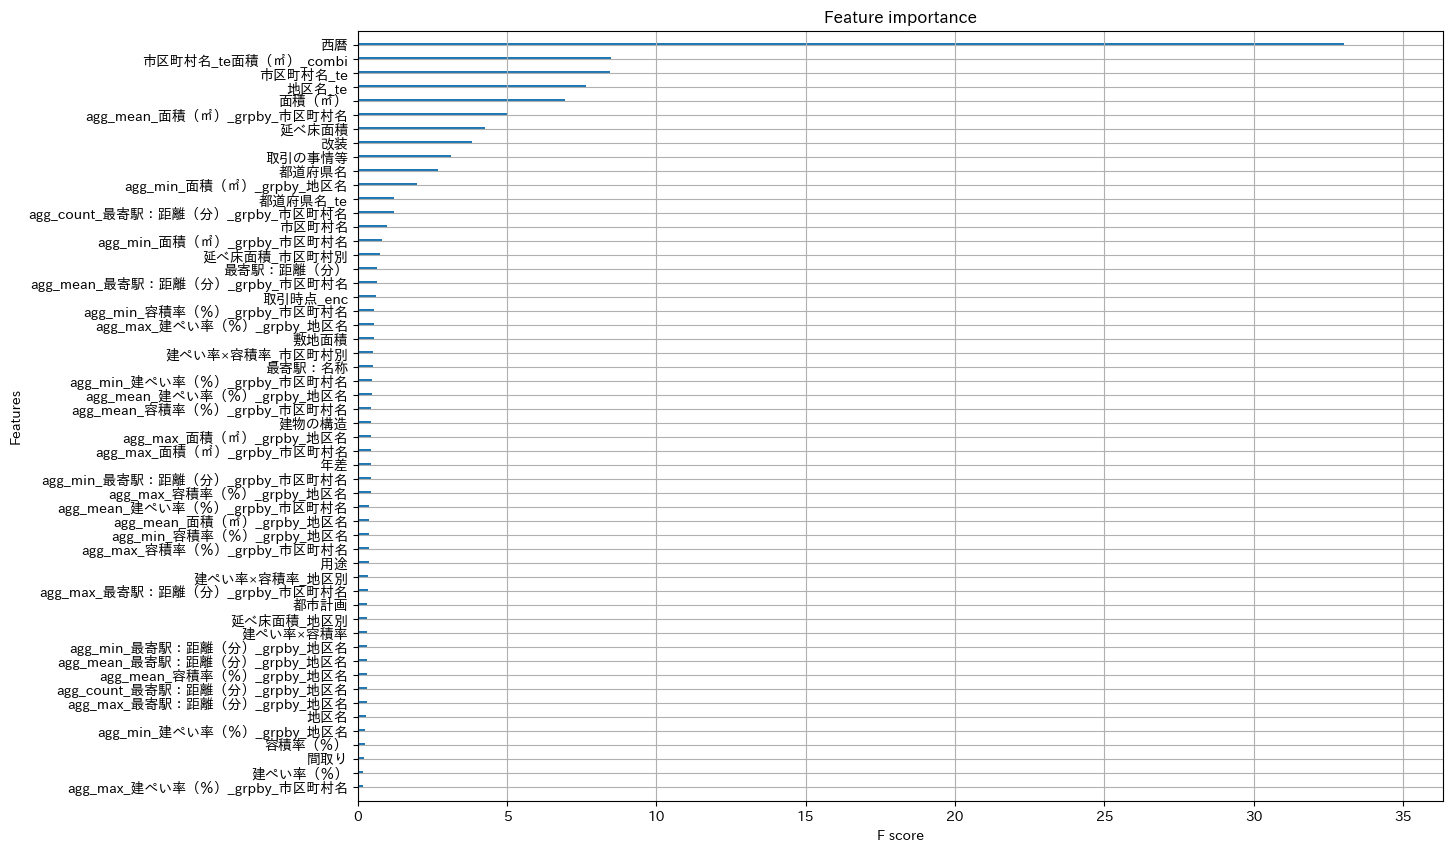

In [45]:
# fig, ax = plt.subplots(figsize=(12, 8))
# xgb.plot_importance(model, importance_type='gain', xlabel='Importance (Gain)', show_values=False)
# plt.show()
_, ax = plt.subplots(figsize=(14, 10))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
plt.show()

In [198]:
X_train

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引時点_enc,市区町村名_te,西暦,市区町村名_te面積（㎡）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,...,間取り,建物の構造,用途,都市計画,改装,取引の事情等,建ぺい率×容積率,敷地面積,延べ床面積,年差
0,12.0,70,60.0,200.0,0,0.000000,1978.0,0.000000,7419,7.440221,...,0,0,0,0,0,0,12000.0,116.666667,233.333333,-27.5
1,11.0,20,80.0,600.0,0,0.000000,2005.0,0.000000,5891,5.372433,...,1,1,0,1,1,0,48000.0,25.000000,150.000000,-0.5
2,8.0,20,80.0,600.0,0,0.000000,1989.0,0.000000,6167,10.715421,...,2,0,0,1,1,0,48000.0,25.000000,150.000000,-16.5
3,14.0,20,80.0,300.0,0,0.000000,1998.0,0.000000,6875,7.141236,...,1,1,0,2,1,0,24000.0,25.000000,75.000000,-7.5
4,10.0,60,60.0,200.0,0,0.000000,1984.0,0.000000,1318,10.550076,...,0,1,0,3,0,0,12000.0,100.000000,200.000000,-21.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547544,3.0,75,60.0,150.0,64,7.215887,1998.0,541.191508,1561,15.691224,...,0,1,0,0,1,0,9000.0,125.000000,187.500000,-23.5
547545,28.0,55,60.0,200.0,64,7.392088,1971.0,406.564862,2627,15.178911,...,6,1,0,0,1,0,12000.0,91.666667,183.333333,-50.5
547546,3.0,85,60.0,300.0,64,7.206771,2009.0,612.575508,763,4.370904,...,0,1,0,4,1,0,18000.0,141.666667,425.000000,-12.5
547547,45.0,65,60.0,200.0,64,7.181237,1998.0,466.780375,4051,12.143915,...,0,1,0,0,1,0,12000.0,108.333333,216.666667,-23.5


In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler
import numpy as np

xgb_r = xgb.XGBRegressor(objective='reg:linear',
                         learning_rate=0.3,
                         reg_lambda=1,
                         n_estimators=400,
                         early_stopping_rounds=20,
                         max_depth=7,
                         seed=121)


# scaler = RobustScaler(quantile_range=(25.0, 75.0))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model with early stopping
xgb_r.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=True)

y_pred_train = xgb_r.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
print("Train RMSE:", rmse_train)

y_pred_test = xgb_r.predict(scaler.transform(X_test))
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)

[23:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.82218
[1]	validation_0-rmse:3.39663
[2]	validation_0-rmse:2.39837
[3]	validation_0-rmse:1.69967
[4]	validation_0-rmse:1.21036
[5]	validation_0-rmse:0.86760
[6]	validation_0-rmse:0.62846
[7]	validation_0-rmse:0.46307
[8]	validation_0-rmse:0.35094
[9]	validation_0-rmse:0.27752
[10]	validation_0-rmse:0.22783
[11]	validation_0-rmse:0.19746
[12]	validation_0-rmse:0.17555
[13]	validation_0-rmse:0.16396
[14]	validation_0-rmse:0.15502
[15]	validation_0-rmse:0.15029
[16]	validation_0-rmse:0.14589
[17]	validation_0-rmse:0.14372
[18]	validation_0-rmse:0.14192
[19]	validation_0-rmse:0.14092
[20]	validation_0-rmse:0.14013
[21]	validation_0-rmse:0.13928
[22]	validation_0-rmse:0.13847
[23]	validation_0-rmse:0.13806
[24]	validation_0-rmse:0.13765
[25]

In [ ]:
# importance_scores = xgb_r.feature_importances_
# feature_names = X_train.columns

# # Display feature importance
# for feature_name, importance_score in zip(feature_names, importance_scores):
#     print(feature_name, importance_score)

In [ ]:
# importance_scores = xgb_r.get_booster().get_score(importance_type='weight')
# # 特徴量の重要度を表示
# for feature_name, importance_score in importance_scores.items():
#     print(feature_name, importance_score)

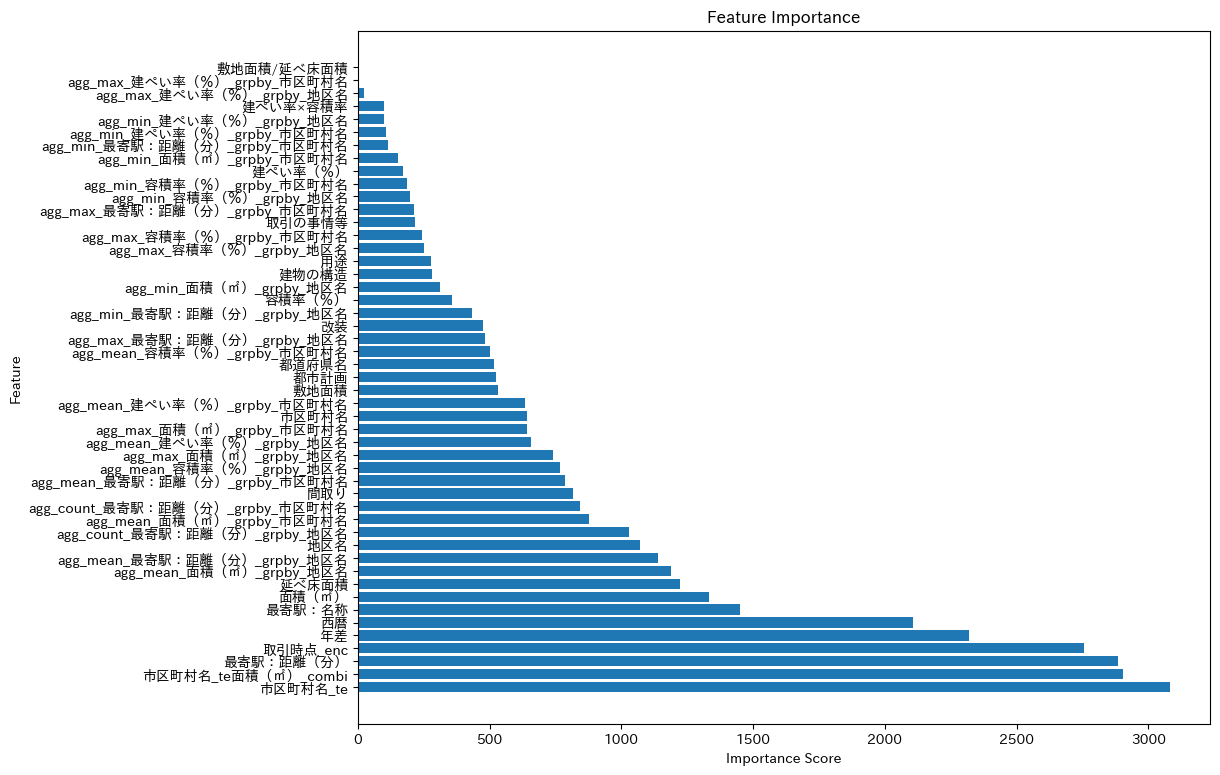

In [378]:
import matplotlib.pyplot as plt
import japanize_matplotlib

importance_scores = xgb_r.get_booster().get_score(importance_type='weight')
feature_names = X_train.columns

importance_values = [importance_scores.get('f{}'.format(i), 0) for i in range(len(feature_names))]

# 重要度の値で降順にソート
sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
importance_values_sorted = [importance_values[i] for i in sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(11, 9))
plt.barh(range(len(importance_values_sorted)), importance_values_sorted, align='center')
plt.yticks(range(len(importance_values_sorted)), feature_names_sorted)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

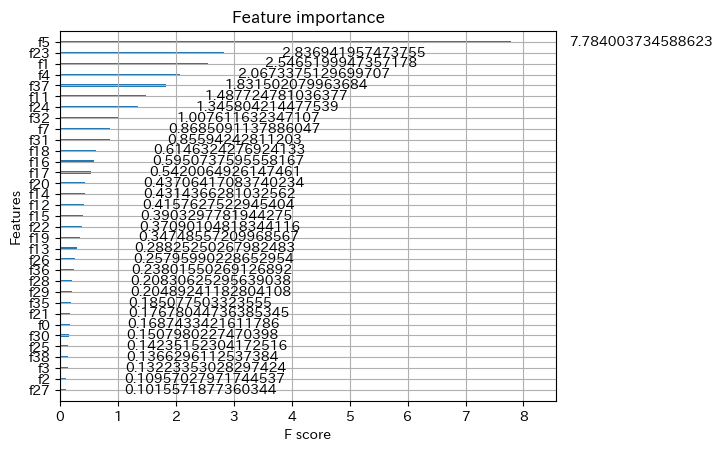

In [107]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r,importance_type='gain')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

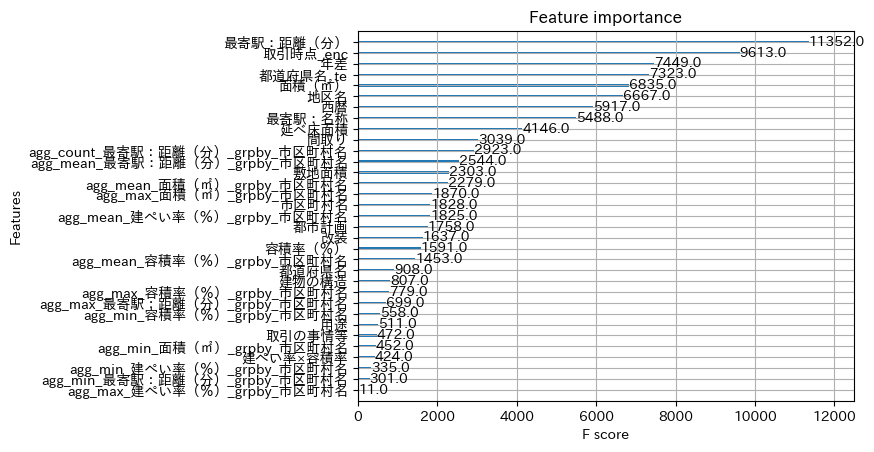

In [112]:
features =df_dummy.columns[df_dummy.any()]
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in xgb_r._Booster.get_fscore().items()}
xgb.plot_importance(mapped,importance_type='cover')

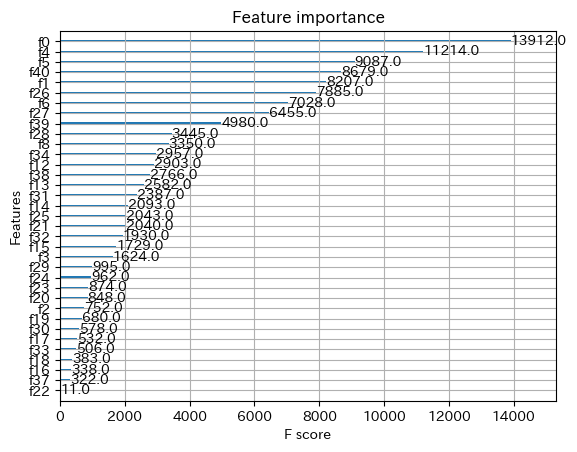

In [100]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r,importance_type='weight')
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_r = xgb.XGBRegressor(objective='reg:linear',
                         learning_rate=0.3, 
                         reg_lambda=1,
                         n_estimators=400,
                         max_depth=8,
                         seed=123)
xgb_r.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)],
         early_stopping_rounds=20)

In [ ]:
# K分割交差検証
from sklearn.model_selection import KFold
 sklearn.model_selection import KFold
# データの分割
kf = KFold(n_splits=5, shuffle=True, random_state=42)
valid_mse = []
i = 1
for train_id, test_id in kf.split(X_set):
   # モデルの学習
    pipe.fit(X_train, y_train)
    # テストデータの予測値とMSEの計算
    y_pred_test = pipe.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    # テストデータでのRMSE
    print('{}Fold テストRMSE: {}'.format(i, np.sqrt(test_mse)))  # 各Kの誤差を表示
    valid_mse.append(np.sqrt(test_mse))  # 各KのテストMSEの平均が検証誤差
    i += 1

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
best_model

In [ ]:

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from itertools import product

# Define the hyperparameter combinations
param_grid = {
    'learning_rate': [0.3, 0.6, 1],
    'max_depth': [6, 8, 11],
    'reg_lambda': [0.5, 1],
    'n_estimators': [300],
    'subsample': [0.6, 1],
    'colsample_bytree': [0.6, 1],
#     'min_child_weight': [1, 5]
}


# Initialize the best model, best parameters, and best accuracy
best_model = None
best_params = None
best_mae = float('inf') 

# Hyperparameter tuning and model evaluation
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    print(param_dict)
    # Create a pipeline with feature scaling and XGBoost classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', xgb.XGBRegressor(**param_dict))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    if mae < best_mae:
        best_mae = mae
        best_model = pipeline
        best_params = params

# Retrain the best model with the entire training set
# best_model.fit(X_train, y_train)

# # Evaluate the final model on the test set
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter combinations
param_grid = {
    'model__learning_rate': [0.3, 0.6, 1],
    'model__max_depth': [3, 6, 9, 11],
    'model__reg_lambda': [0.5, 1],
    'model__n_estimators': [200, 400, 600],
    'model__subsample': [0.5, 0.75, 1],
    'model__colsample_bytree': [0.5, 0.75, 1],
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0, 0.1, 0.5, 1, 3]
}

# Create a pipeline with feature scaling and XGBoost regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor())
])

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model, best parameters, and best MAE
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
# y_pred = best_model.predict(X_test)
# best_mae = mean_absolute_error(y_val, y_pred)